# GAM

#### Author: leebond

#### Date: Feb 2020


## Contents:
apply gam model and demonstrate the fit for
- Case 1 (overall)
- Case 2 (Hubei only)
- Case 3 (ex-Hubei)
   
## Summary


In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
import datetime
import matplotlib.dates as mdates
from helper_fun_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
## Update data from DXY
! cd ../data_processing && python DXY_AreaData_query.py

Latest Update Time:  2020-02-09 13:33:40.433000
Data Range:  2020-01-24 to 2020-02-09
Data Size:  27138
梅河口cannot be translated, ask Yiran to mannully Translate

Save area daily dataset (English) into ../data/DXYArea.csv
CPU times: user 116 ms, sys: 39.3 ms, total: 155 ms
Wall time: 9.17 s


In [3]:
## Load data 
DXYArea = pd.read_csv("../data/DXYArea.csv")
DXYArea = add_days(DXYArea) # add the number of days after 2019-12-08
DXYArea.tail(3) # check new

,provinceName,cityName,confirmed,cured,dead,updateTime,updateDate,Days
6069,Heilongjiang Province,Hegang,4,0,0,2020-02-09 08:55:45.123,2020-02-09,63
6070,Heilongjiang Province,Heihe,2,0,0,2020-02-09 08:55:45.123,2020-02-09,63
6071,Heilongjiang Province,Qiqihar,27,0,0,2020-02-09 08:55:45.123,2020-02-09,63


### Case1: Overall 

In [4]:
"""
Sum up all province  
"""
# China total
overall_df = pd.DataFrame(DXYArea.groupby(['updateDate']).agg({'confirmed': "sum",
                                                                'cured': "sum",
                                                                'dead': 'sum',
                                                                'Days': 'mean'})).reset_index()


#### Feature Engineering

In [5]:
overall_df['confirmed'].shift()

0         NaN
1       876.0
2      1354.0
3      2020.0
4      2852.0
5      4668.0
6      6075.0
7      7781.0
8     10071.0
9     12028.0
10    14456.0
11    17523.0
12    20497.0
13    24357.0
14    28094.0
15    31201.0
16    34600.0
Name: confirmed, dtype: float64

In [6]:
overall_df['confirmed_lag1'] = overall_df['confirmed'].shift()

In [19]:
overall_df['confirmed_lag1'].fillna(0, inplace = True)

In [20]:
Train, Test = split_train_test_by_date(overall_df, 5)

X_train = Train[['Days', 'confirmed_lag1']]
y_train = Train['confirmed']
X_test =  Test[['Days', 'confirmed_lag1']]
y_test = Test['confirmed']

Train dataset: data before 2020-02-04 00:00:00 
Test dataset: the last 5 days


In [21]:
from pygam import PoissonGAM, s, te, l

In [22]:
gam = PoissonGAM(s(0, n_splines=5) + l(1) ).fit(X_train, y_train)

In [23]:
gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                      5.8105
Link Function:                          LogLink Log Likelihood:                                   -70.6307
Number of Samples:                           11 AIC:                                              152.8825
                                                AICc:                                             186.2385
                                                UBRE:                                               5.9708
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9994
Feature Function                  Lam

In [24]:
y_train_predicted = gam.predict(X_train)
y_test_predicted = gam.predict(X_test)

In [25]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}\n".format(r2_train))

RMSE of training set is 108.63026964459375
R2 score of training set is 0.9995926551689577



In [26]:
y_test

11    20497
12    24357
13    28094
14    31201
15    34600
16    36995
Name: confirmed, dtype: int64

In [27]:
y_test_predicted

array([20367.05494049, 23872.30619366, 26336.32738317, 29300.01977048,
       34031.82896521, 38746.56418227])

In [28]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predicted))
r2_test = r2_score(y_test, y_test_predicted)
print("RMSE of testing set is {}".format(rmse_test))
print("R2 score of testing set is {}\n".format(r2_test))

RMSE of testing set is 1313.1227458989722
R2 score of testing set is 0.9467528635737907



## Polynomial regression

In [9]:
"""
Sum up all province  
"""
# China total
overall_df = pd.DataFrame(DXYArea.groupby(['updateDate']).agg({'confirmed': "sum",
                                                                'cured': "sum",
                                                                'dead': 'sum',
                                                                'Days': 'mean'})).reset_index()
Train, Test = split_train_test_by_date(overall_df)

X_train = Train['Days']
y_train = Train['confirmed']
X_test =  Test['Days']
y_test = Test['confirmed']

Train dataset: data before 2020-01-30 00:00:00 
Test dataset: the last 10 days


### Case1: Overall 

Degree 1:
RMSE of training set is 432.6537638401859
R2 score of training set is 0.945043576678515

RMSE of test set is 11606.77526070426
R2 score of test set is -0.4360240060756915
---------------------------------------

Degree 3:
RMSE of training set is 131.69973966793492
R2 score of training set is 0.9949077780944563

RMSE of test set is 1316.287520038485
R2 score of test set is 0.9815311405317501
---------------------------------------

Degree 2:
RMSE of training set is 132.6872127545397
R2 score of training set is 0.9948311297507825

RMSE of test set is 4364.768196845042
R2 score of test set is 0.7969229164229359
---------------------------------------



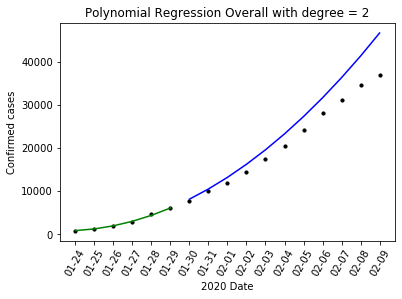

In [10]:
"""
Model selection:
  find optimal degree level
  Then draw plot using the optimal degree
"""
# select the best degree 
create_polynomial_regression_model(1, "Overall", overall_df, X_train, X_test, y_train, y_test, draw_plot = False)
create_polynomial_regression_model(3, "Overall", overall_df, X_train, X_test, y_train, y_test, draw_plot = False)
create_polynomial_regression_model(2, "Overall", overall_df, X_train, X_test, y_train, y_test, draw_plot = True)

**based on the result above, we can clearly see that degree = 2 gives us best estimation. So now we use degree = 2 to predict the next 4 days**

Degree 2:
RMSE of training set is 297.6580589182098
R2 score of training set is 0.9992487131906561

---------------------------------------



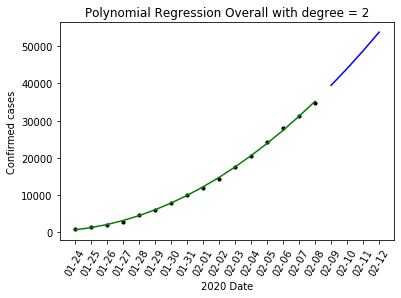

In [9]:
forecast_next_4_days(2, "Overall", overall_df)

### Case2: Each Province

Train dataset: data before 2020-02-06 00:00:00 
Test dataset: the last 3 days
Degree 1:
RMSE of training set is 1400.4742561046387
R2 score of training set is 0.9226740677396366

RMSE of test set is 5992.177104992286
R2 score of test set is -6.69014841400451
---------------------------------------

Degree 3:
RMSE of training set is 163.6631392992854
R2 score of training set is 0.9989439690187146

RMSE of test set is 1495.2000531131437
R2 score of test set is 0.521189079294307
---------------------------------------

Degree 2:
RMSE of training set is 237.2133877906418
R2 score of training set is 0.9977815313454274

RMSE of test set is 434.0727925730869
R2 score of test set is 0.9596456301170528
---------------------------------------



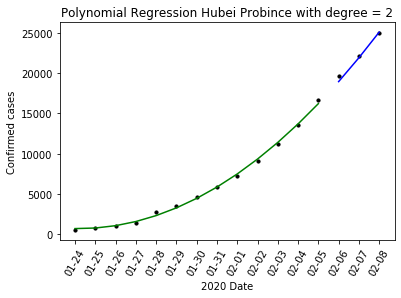

Degree 2:
RMSE of training set is 297.6580589182098
R2 score of training set is 0.9992487131906561

---------------------------------------



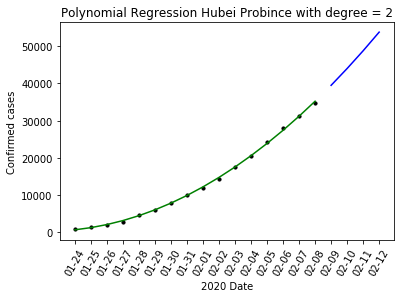

In [10]:
# See Hubei Province 
Hubei= DXYArea[DXYArea['provinceName'] == 'Hubei Province']
 
X_train, X_test, y_train, y_test = data_processing(Hubei)    

# select the best degree 
create_polynomial_regression_model(1, "Hubei Probince", overall_df, X_train, X_test, y_train, y_test, draw_plot = False)
create_polynomial_regression_model(3, "Hubei Probince", overall_df, X_train, X_test, y_train, y_test, draw_plot = False)
create_polynomial_regression_model(2, "Hubei Probince", overall_df, X_train, X_test, y_train, y_test, draw_plot = True)

forecast_next_4_days(2, "Hubei Probince", overall_df)

Train dataset: data before 2020-02-06 00:00:00 
Test dataset: the last 3 days
Degree 1:
RMSE of training set is 285.14341796386464
R2 score of training set is 0.9861016952837389

RMSE of test set is 351.0548151138066
R2 score of test set is 0.5027297394420859
---------------------------------------

Degree 3:
RMSE of training set is 89.6359273810185
R2 score of training set is 0.998626592675521

RMSE of test set is 310.8504972967935
R2 score of test set is 0.6101067187866627
---------------------------------------



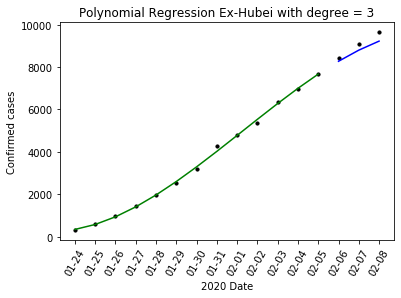

Degree 2:
RMSE of training set is 145.3798893459301
R2 score of training set is 0.9963872010424277

RMSE of test set is 712.6828547445574
R2 score of test set is -1.0494401507749278
---------------------------------------

Degree 2:
RMSE of training set is 297.6580589182098
R2 score of training set is 0.9992487131906561

---------------------------------------



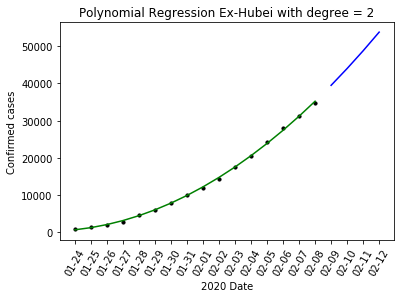

In [13]:
# See Hubei Province 
NotHubei= DXYArea[DXYArea['provinceName'] != 'Hubei Province']
 
X_train, X_test, y_train, y_test = data_processing(NotHubei)    

# select the best degree 
create_polynomial_regression_model(1, "Ex-Hubei", overall_df, X_train, X_test, y_train, y_test, draw_plot = False)
create_polynomial_regression_model(3, "Ex-Hubei", overall_df, X_train, X_test, y_train, y_test, draw_plot = True)
create_polynomial_regression_model(2, "Ex-Hubei", overall_df, X_train, X_test, y_train, y_test, draw_plot = False)

forecast_next_4_days(3, "Ex-Hubei", overall_df)